<a href="https://colab.research.google.com/github/pbluc3m/collab-R/blob/main/Introducci%C3%B3n_simmer_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uso del *package* **simmer** en *Google Collab*

Hay que abrir un notebook y asegurarse que de que runtime (Runtype -> change runtype type) sea R (en vez de Python).

Posteriormente, lo primero es instalar el package de simmer (lleva cierto tiempo)




In [ ]:
install.packages("simmer")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Rcpp’




A continuación, se carga dicho package, se fija una semilla para la generación de variables aleatorias, y se crea un entorno de simulación

In [ ]:
library(simmer)
set.seed(42)
env <- simmer("Ejemplo")


El entorno se puede eliminar completamente con el comando
```
rm(env)
```

# Trayectorias, recursos y usuarios

Se define un tipo de usuario que va a visitar tres estaciones en serie: A, B y C.

* En la estación A ocupa un servidor durante un tiempo fijo de 5 unidades.
* En la estación B ocupa un servidor durante un tiempo aleatorio exponencial de media 10.
* En la estación C ocupa dos servidores durante un tiempo aleatorio uniformemente distribuido entre 2 y 12.

Este comportamiento se define con el siguiente código:


In [ ]:
usuario <- trajectory("TrayectoriaABC") %>%
  # Estación A
  seize("A", 1) %>%
  timeout(5) %>%
  release("A", 1) %>%
  # Estación B
  seize("B", 1) %>%
  timeout(function() rexp(1, 1/10)) %>%
  release("B", 1) %>%
  # Estación C
  seize("C", 2) %>%
  timeout(function() runif(1, 2, 12)) %>%
  release("C", 2)

**Aclaración:** en R, el operador %>% se conoce como el operador de tubería (pipe operator). El propósito del operador es escribir código más limpio y legible al permitir encadenar comandos en una secuencia.

De esta forma, un código "tradicional":


```
result <- someFunction(df, arg1)
result <- anotherFunction(result, arg2)
result <- yetAnotherFunction(result, arg3)
```

Se puede escribir como

```
result <- df %>%
  someFunction(arg1) %>%
  anotherFunction(arg2) %>%
  yetAnotherFunction(arg3)
```


Por otra parte, hay que asignar recursos a las estaciones que visitará el usuario: se añaden 2 recursos a la estación A, 2 a la estación B y 6 a la estación C.

In [ ]:
env %>%
    add_resource("A", 2) %>%
    add_resource("B", 2) %>%
    add_resource("C", 6)

simmer environment: Ejemplo | now: 0 | next: 
{ Monitor: in memory }
{ Resource: A | monitored: TRUE | server status: 0(2) | queue status: 0(Inf) }
{ Resource: B | monitored: TRUE | server status: 0(2) | queue status: 0(Inf) }
{ Resource: C | monitored: TRUE | server status: 0(6) | queue status: 0(Inf) }

Falta por último un elemento que genere usuarios según la trayectoria definida:

In [ ]:
env %>%
  add_generator("Usuarios", usuario, function() runif(1, 5, 45))


simmer environment: Ejemplo | now: 0 | next: 0
{ Monitor: in memory }
{ Resource: A | monitored: TRUE | server status: 0(2) | queue status: 0(Inf) }
{ Resource: B | monitored: TRUE | server status: 0(2) | queue status: 0(Inf) }
{ Resource: C | monitored: TRUE | server status: 0(6) | queue status: 0(Inf) }
{ Source: Usuarios | monitored: 1 | n_generated: 0 }

# Ejecución y análisis de una simulación

Con lo anterior, ya se disponen de los elementos para hacer una simulación. Por ejemplo, si se simula durante 125 unidades de tiempo, tendrían que haber llegado aproximadamente 5 usuarios (y terminado alguno de ellos)

In [ ]:
env %>%
  run(125)

simmer environment: Ejemplo | now: 125 | next: 125.131742917001
{ Monitor: in memory }
{ Resource: A | monitored: TRUE | server status: 0(2) | queue status: 0(Inf) }
{ Resource: B | monitored: TRUE | server status: 0(2) | queue status: 0(Inf) }
{ Resource: C | monitored: TRUE | server status: 2(6) | queue status: 0(Inf) }
{ Source: Usuarios | monitored: 1 | n_generated: 4 }

Se puede analizar la actividad en la simulación. Por ejemplo, con el siguiente comando se puede analizar cómo se han comportado los usuarios en el uso de los recursos (per_resource = TRUE) y teniendo en cuenta a los usuarios que no hayan terminado sino que sigan "en curso" (ongoing = TRUE)


In [ ]:
env %>%
  get_mon_arrivals(per_resource = TRUE, ongoing=TRUE)

name,start_time,end_time,activity_time,resource,replication
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Usuarios0,41.59224,46.59224,5.000000,A,1
Usuarios0,46.59224,54.96929,8.377053,B,1
Usuarios0,54.96929,65.27377,10.304476,C,1
Usuarios1,84.07526,89.07526,5.000000,A,1
Usuarios1,89.07526,89.45718,0.381919,B,1
Usuarios1,89.45718,98.82306,9.365883,C,1
Usuarios2,114.74508,119.74508,5.000000,A,1
Usuarios2,119.74508,122.88492,3.139846,B,1
Usuarios2,114.74508,NA,NA,A,1


También se puede mostrar información sólo de los usuarios que han completado la trayectoria

In [ ]:
env %>%
  get_mon_arrivals()

name,start_time,end_time,activity_time,finished,replication
<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<int>
Usuarios0,41.59224,65.27377,23.68153,TRUE,1
Usuarios1,84.07526,98.82306,14.74780,TRUE,1


O bien el comportamiento de los recursos a lo largo de la simuación:

In [ ]:
env %>%
  get_mon_resources()

resource,time,server,queue,capacity,queue_size,system,limit,replication
<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>
A,41.59224,1,0,2,Inf,1,Inf,1
A,46.59224,0,0,2,Inf,0,Inf,1
B,46.59224,1,0,2,Inf,1,Inf,1
B,54.96929,0,0,2,Inf,0,Inf,1
C,54.96929,2,0,6,Inf,2,Inf,1
C,65.27377,0,0,6,Inf,0,Inf,1
A,84.07526,1,0,2,Inf,1,Inf,1
A,89.07526,0,0,2,Inf,0,Inf,1
B,89.07526,1,0,2,Inf,1,Inf,1


Se puede continuar con la ejecución de la simulación, por ejemplo, durante 2500 unidades de tiempo

In [ ]:
env %>%
  run(2500)

simmer environment: Ejemplo | now: 2500 | next: 2501.91122253891
{ Monitor: in memory }
{ Resource: A | monitored: TRUE | server status: 0(2) | queue status: 0(Inf) }
{ Resource: B | monitored: TRUE | server status: 1(2) | queue status: 0(Inf) }
{ Resource: C | monitored: TRUE | server status: 0(6) | queue status: 0(Inf) }
{ Source: Usuarios | monitored: 1 | n_generated: 106 }

Y, por ejemplo, procesar el dataframe de los datos de los usuarios que han terminado para calcular el tiempo de estancia en el sistema de cada uno

In [ ]:
user_stats <- get_mon_arrivals(env)
tiempo_total = user_stats$end_time - user_stats$start_time

Se puede calcular el valor medio de este tiempo, o pintar su función de distribución (y analizar si el tiempo mínimo observado resulta razonable)

[1] 23.44924

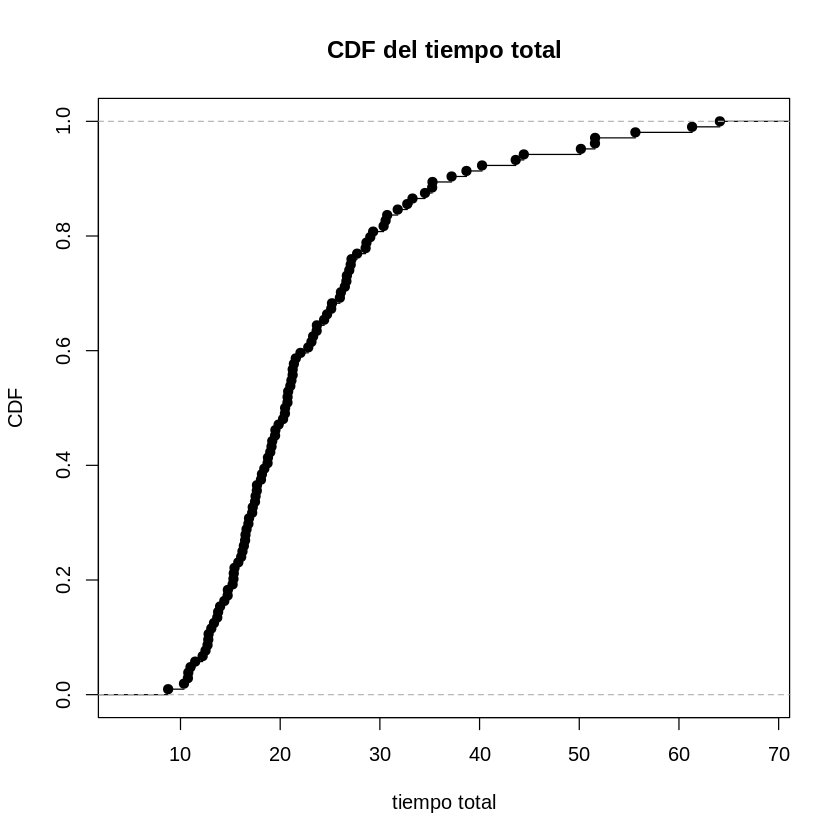

In [ ]:
tiempo_total_medio = mean(tiempo_total)
tiempo_total_medio

ecdf_tiempo_total <- ecdf(tiempo_total)
plot(ecdf_tiempo_total, main="CDF del tiempo total", xlab="tiempo total", ylab="CDF")

# Uso de varias réplicas

El valor del tiempo medio de una única simulación proporciona poca información estadística. Por ello se suele ejecutar varias veces la simulación (esto es, ejecutar varias réplicas), y procesar la información resultante. Esto se puede realizar en paralelo con diferentes entornos de ejecución mediante la librería "parallel", y los comandos "mclappy" (para paralelizar) y wrap (para recuperar los resultados de cada hilo). Para tener suficientes usuarios, se ejecuta la simulación durante 5000 unidades de tiempo:







In [ ]:
library(parallel)

envs <- mclapply(1:100, function(i) {
  simmer("Ejemplo Paralelo") %>%
    add_resource("A", 1) %>%
    add_resource("B", 2) %>%
    add_resource("C", 6) %>%
    add_generator("Usuarios", usuario, function() runif(1,5, 45)) %>%
    run(2500) %>%
    wrap()
})

Una vez completadas las réplicas, se pueden analizar los resultados con más información estadística. Para ello, hay que instalar (lleva cierto tiempo) y cargar la librería de representación visual "simmer.plot"

In [ ]:
install.packages("simmer.plot")
library(simmer.plot)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gridExtra’, ‘downloader’, ‘htmlwidgets’, ‘igraph’, ‘viridis’, ‘visNetwork’, ‘DiagrammeR’


Loading required package: ggplot2


Attaching package: ‘simmer.plot’


The following objects are masked from ‘package:simmer’:

    get_mon_arrivals, get_mon_attributes, get_mon_resources




Por ejemplo, a continuación se representa la utilización de las distintas estaciones:

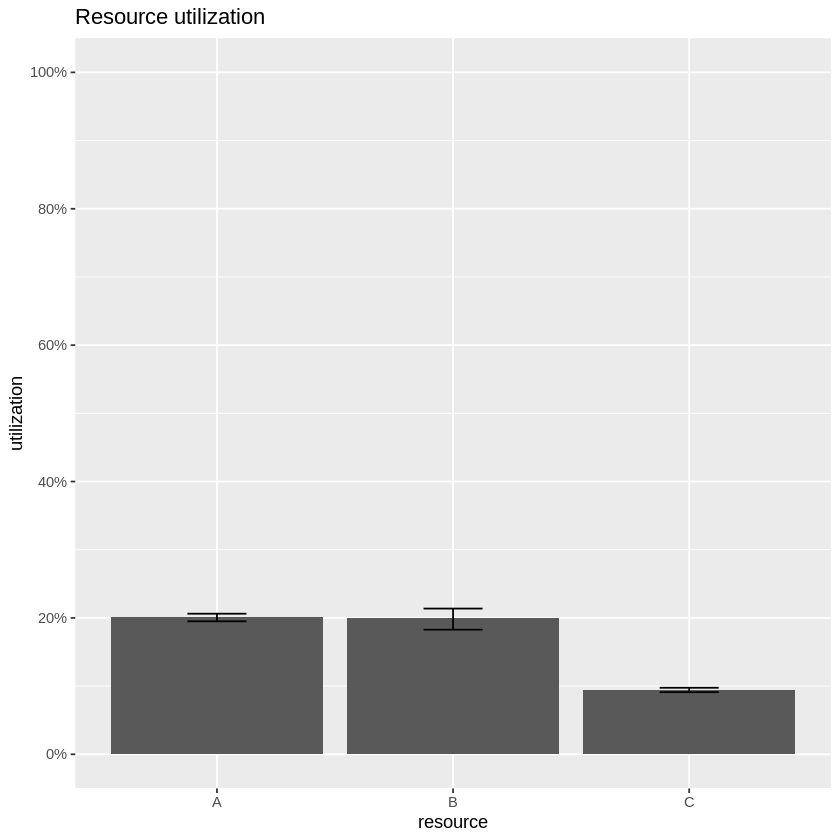

In [ ]:
resources <- get_mon_resources(envs)
plot(resources, metric = "utilization")

También se puede representar cómo evoluciona el tiempo medio de estancia en el sistema a lo largo del tiempo:

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


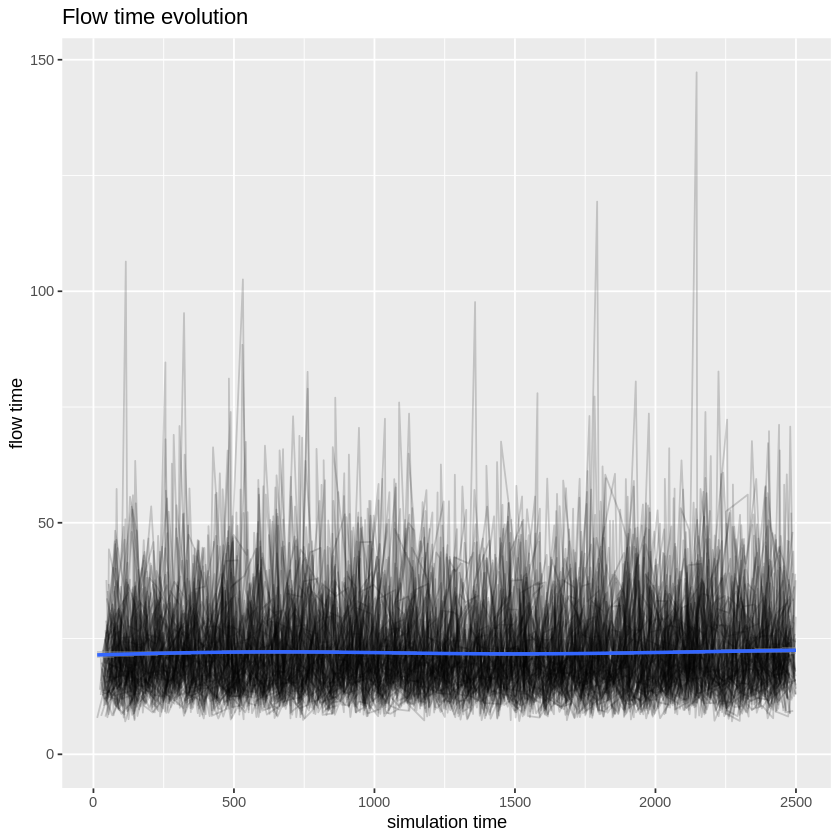

In [ ]:
arrivals <- get_mon_arrivals(envs)
plot(arrivals, metric = "flow_time")

Se puede analizar qué pasaría si se añadiese un recurso más a la estación A:

In [ ]:
envs <- mclapply(1:100, function(i) {
  simmer("Ejemplo Paralelo") %>%
    add_resource("A", 2) %>%
    add_resource("B", 2) %>%
    add_resource("C", 6) %>%
    add_generator("Usuarios", usuario, function() runif(1,5,45)) %>%
    run(2500) %>%
    wrap()
})

La ocupación de los recursos se ve modificada como

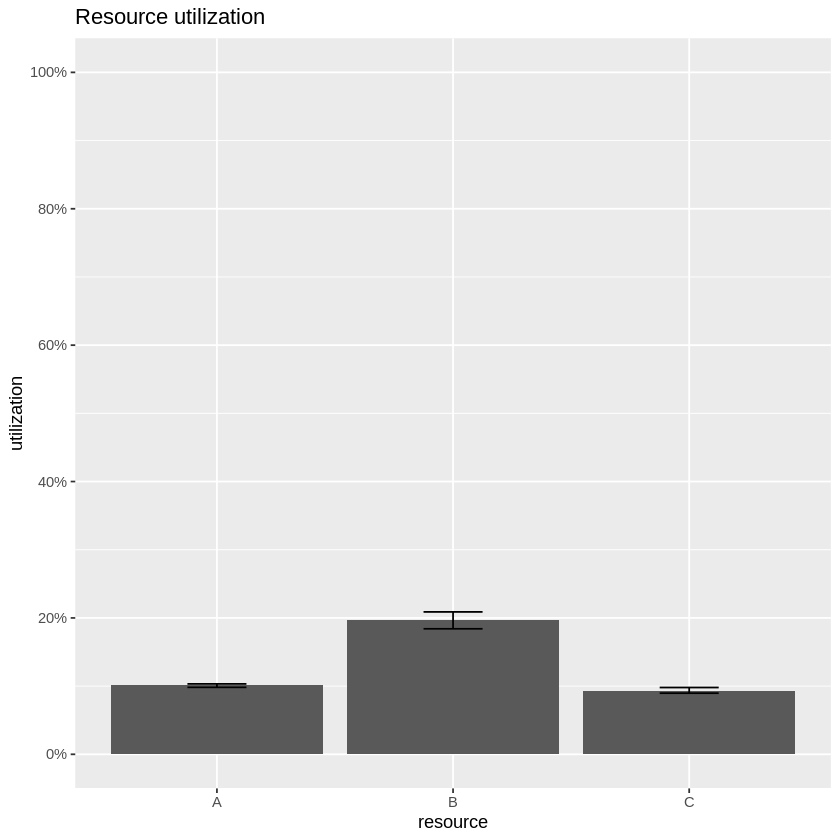

In [ ]:
resources <- get_mon_resources(envs)
plot(resources, metric = "utilization")

Mientras que el tiempo medio de estancia resulta:

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


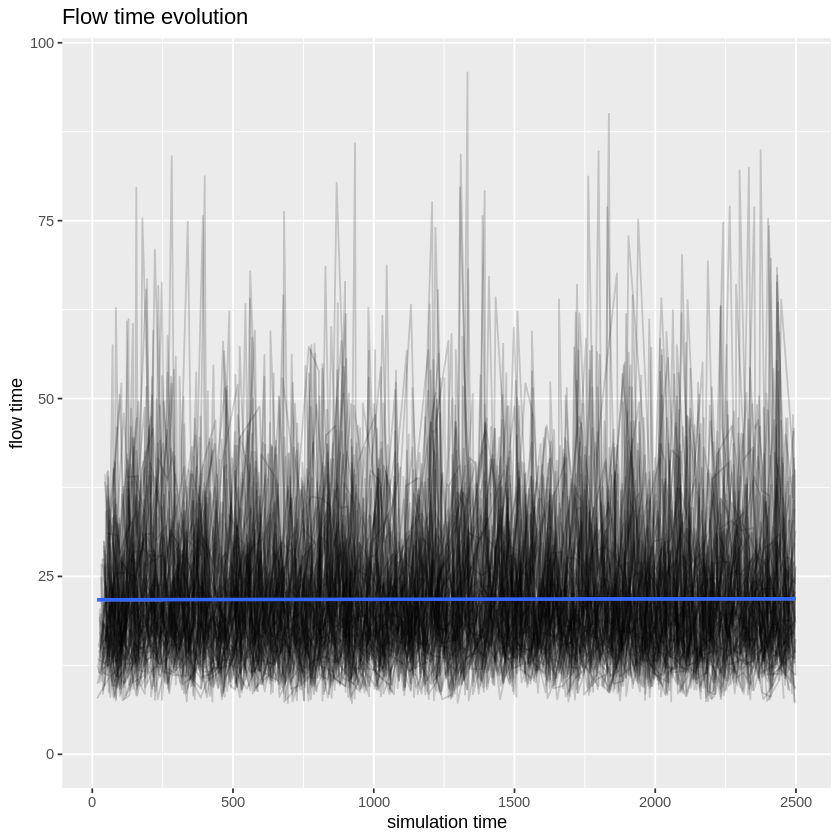

In [ ]:
arrivals <- get_mon_arrivals(envs)
plot(arrivals, metric = "flow_time")

In [ ]:
mean(arrivals$end_time-arrivals$start_time)

[1] 20.79487

# Varias trayectorias

Sobre la topología anterior, se puede definir una nueva trayectoria para otro tipo de usuario, que únicamente visite los recursos A y C.

En la estación A requiere un recurso durante un tiempo exponencial 5, mientras que en la estación C requiere tres recursos durante un tiempo exponencial 5.

In [ ]:
usuarioAC <- trajectory("TrayectoriaAC") %>%
  # Estación A
  seize("A", 1) %>%
  timeout(function() rexp(1,1/5)) %>%
  release("A", 1) %>%
  # Estación C
  seize("C", 3) %>%
  timeout(function() rexp(1,1/7)) %>%
  release("C", 3)

Se realiza una serie de simulaciones con este nuevo usuario, a una tasa igual que el primer usuario

In [ ]:
envs <- mclapply(1:100, function(i) {
  simmer("Ejemplo Paralelo") %>%
    add_resource("A", 2) %>%
    add_resource("B", 2) %>%
    add_resource("C", 6) %>%
    add_generator("Usuarios", usuario, function() runif(1,5,45)) %>%
    add_generator("UsuariosAC", usuarioAC, function() runif(1,5,45)) %>%
    run(2500) %>%
    wrap()
})

Se puede ver un incremento en la ocupación de los recursos A y C respecto al caso anterior

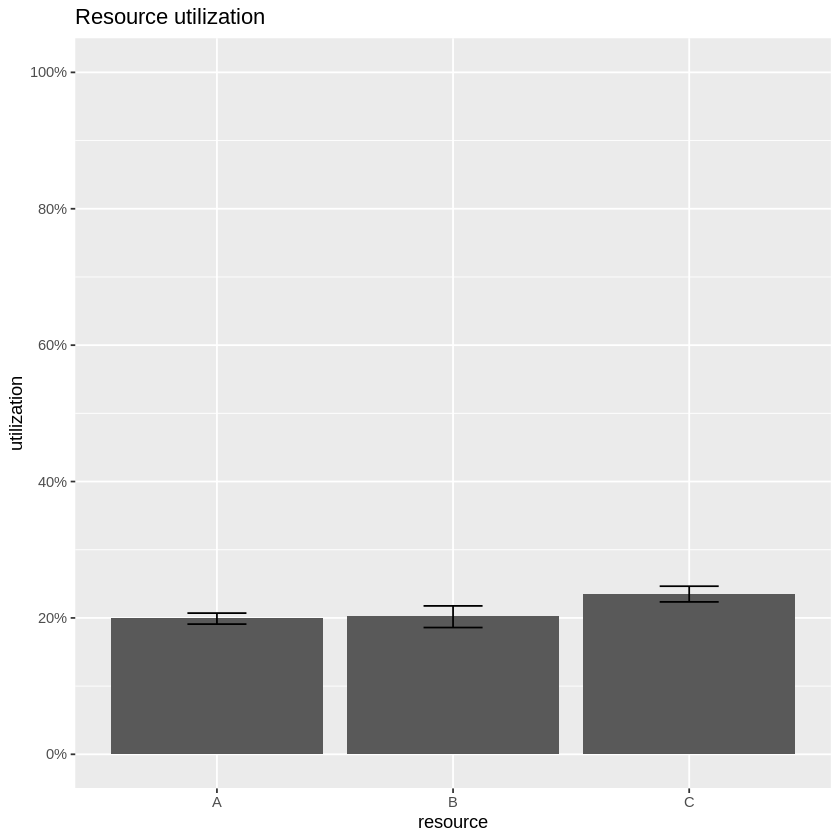

In [ ]:
resources <- get_mon_resources(envs)
plot(resources, metric = "utilization")

IÑAKI: CÓMO PINTO EL FLOW TIME DE DIFERENTES FLOWS

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


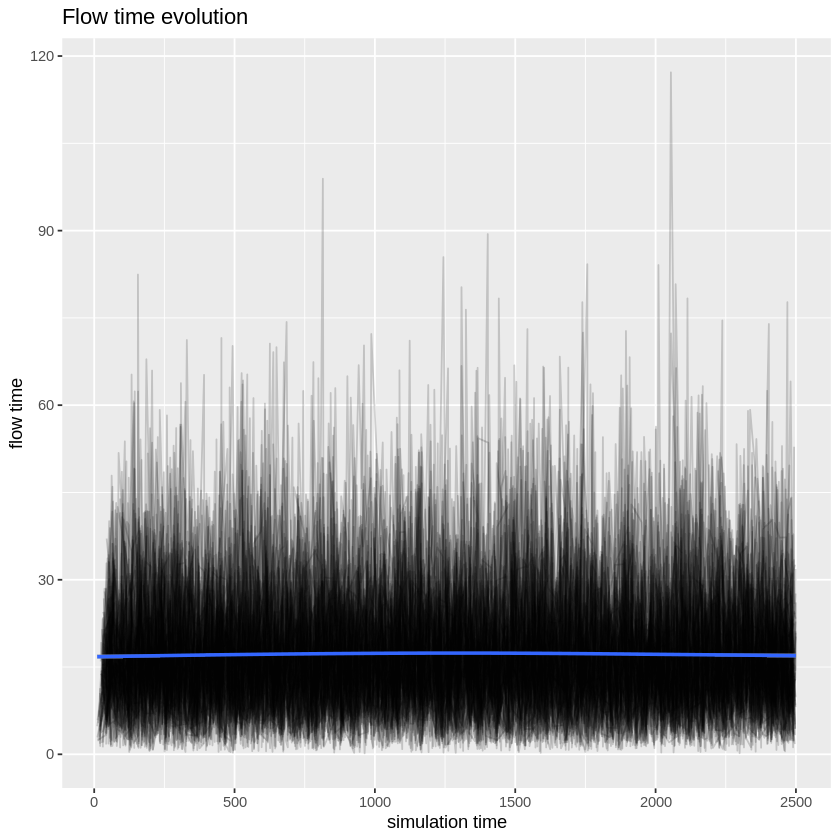

In [ ]:
arrivals <- get_mon_arrivals(envs)
plot(arrivals, metric = "flow_time")

# Más información

Se recomienda consultar las guías disponibles en la página web del *package* simmer: https://r-simmer.org/articles/